In [1]:
import torch
import torchvision
import numpy as np
import sys
import torchvision.transforms as transforms
sys.path.append('..')
import d2lzh_pytorch as d2l

##### 获取和读取数据

我们将使用Fahsion_MNIST数据集，并设置批量大小为256

In [2]:
batch_size= 256
mnist_train= torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',download=True,train=True,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',download=True,train=False,transform=transforms.ToTensor())

if sys.platform.startswith('win'):
    num_worker=0   # 表示不用额外的进程来加速读取数据
    
else:
    num_worker=4
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_worker)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=num_worker)


##### 初始化模型参数

与线性回归中的例子一样，我们将使用向量表示每个样本。已知每个样本输入是高和宽均为像素28的图像，模型输入向量的长度为28*28=784；该向量的每个元素对应图中每个元素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别是784x10 和1x10的矩阵。

In [3]:
num_inputs= 784
num_outputs = 10
W = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float)
b = torch.zeros(num_outputs,dtype=torch.float)

In [4]:
# 同之前一样，我们需要模型参数梯度
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

##### 实现softmax运算

In [5]:
'''
在实现softmax回归之前，我们先描述回下对多维Tensor按照维度进行操作。
跟之前pandas的里面对于DataFrame的操作一样，对于axis或者维度的进行操作
下面给定一个Tensor矩阵X，可以对于其中同一列dim=0或者同一行的元素进行操作，
并在结果中保留行和列两个维度(keepdim=True)
'''
X= torch.tensor([[1,2,3],[4,5,6]])
print(X)
print('沿着列进行操作\n',X.sum(dim=0,keepdim=True))
print('沿着行进行操作\n',X.sum(dim=1,keepdim=True))

tensor([[1, 2, 3],
        [4, 5, 6]])
沿着列进行操作
 tensor([[5, 7, 9]])
沿着行进行操作
 tensor([[ 6],
        [15]])


In [6]:
'''
1. 先规定X矩阵的中行数为样本数，列数为输出个数。为了表示样本预测各个输出的概率，
2. softmax运算会先通过exp函数对每个元素做指数运算，在对exp矩阵同行元素求和
3. 然后令矩阵每行元素与该行元素之和相除。
4. 这样，最终得到的矩阵每行元素和为1且非负，符合概率分布。
5. softmax运算的输出矩阵中的任一行元素代表了一个样本在各个输出类别上个预测概率
'''
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1,keepdim=True)
    return X_exp/partition




In [7]:
X = torch.rand((2,5))
X_prob = softmax(X)
print(X_prob)
print(X_prob.sum(dim=1))

tensor([[0.2524, 0.1500, 0.2120, 0.1873, 0.1982],
        [0.2157, 0.1602, 0.3160, 0.1392, 0.1689]])
tensor([1., 1.])


#####  定义模型

有了softmax运算，我们就可以定义上节描述的回归模型了。这个通过view函数将每张原始图像改成长度为num_inputs的向量

In [8]:
def net(X):
    return softmax(torch.mm(X.view(-1,num_inputs),W)+b)

##### 定义损失函数

上节中，我们介绍了softmax回归使用的交叉熵损失函数。为了得到标签的预测概率，我们可以使用father函数。在下面的例子中，变量y_hat是2个样本在3个类别的预测概率，变量y是两个样本的标签类别。使用gather函数，我们得到了2个样本的标签预测概率

In [9]:
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y = torch.LongTensor([0,2])
y_hat.gather(1,y.view(-1,1))
# 这里需要单独讲一下，y.view(-1,1)是将y变形成2行1列的tensor
# 然后从y_hat中去取第一行中的第一个元素和第二行中的第三个元素

tensor([[0.1000],
        [0.5000]])

In [10]:
def cross_entropy(y_hat,y):
    return - torch.log(y_hat.gather(1,y.view(-1,1)))

In [11]:
cross_entropy(y_hat,y)

tensor([[2.3026],
        [0.6931]])

##### 计算分类准确率

- 给定一个类别的预测概率分布y_hat，我们预测概率最大的类别作为输出类别。如果它与真实的类别y一致，说明预测正确，分类准确率=正确预测数量/总预测量只比


- 为了演示准确率的计算，下面定义准确率定义函数


In [12]:
def accuracy(y_hat,y):
    return (y_hat.argmax(dim=1)==y).float().mean().item()

In [13]:
print(accuracy(y_hat,y))

0.5


In [14]:

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [15]:
# print(evaluate_accuracy(test_iter,net))
# 初始化模型后对测试集的准确率

##### 训练模型

softmax回归于实现线性回归类似，同样适用小批量随机梯度下降来优化模型的损失函数。在训练模型时，迭代周期数num_epochs和学习率lr都是可以调节的超参数。

In [16]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -=lr* param.grad/batch_size   

In [17]:
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))



        

In [18]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7850, train acc 0.750, test acc 0.786
epoch 2, loss 0.5705, train acc 0.814, test acc 0.810
epoch 3, loss 0.5254, train acc 0.825, test acc 0.814
epoch 4, loss 0.5017, train acc 0.832, test acc 0.822
epoch 5, loss 0.4854, train acc 0.836, test acc 0.826


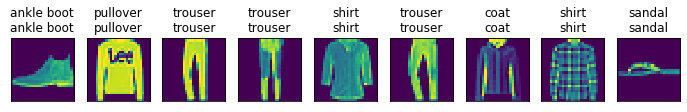

In [19]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])


##### 小结

1. 获取并读取数据,拆分数据集
2. 定义模型和损失函数并使用优化算法训练模型
3. 评估模型